In [2]:
!pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 32.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
import numpy as np
from transformers import AutoTokenizer



In [3]:

# Load CSV
df = pd.read_csv("/content/drive/MyDrive/amazon_reviews_Mobile_Electronics.csv")

# Drop rows with missing values in relevant columns
df = df[['review_body', 'star_rating']].dropna()

# Convert star_rating to integer
df['star_rating'] = df['star_rating'].astype(int)

# Map star_rating to sentiment classes
def map_rating(r):
    if r <= 2:
        return 0  # negative
    elif r == 3:
        return 1  # neutral
    else:
        return 2  # positive

df['sentiment'] = df['star_rating'].apply(map_rating)

# Rename 'review_body' to 'reviews'
df = df.rename(columns={'review_body': 'reviews'})

# Keep only the renamed columns
df = df[['reviews', 'sentiment']]

# Optionally save to CSV
df.to_csv("cleaned_data.csv", index=False)

# Display a sample
print(df.head())


                                             reviews  sentiment
0  As advertised. Everything works perfectly, I'm...          2
1                                         it's great          2
2  These work great and fit my life proof case fo...          2
3  Work very well but couldn't get used to not he...          2
4  Be careful with these products, I have bought ...          0


#### Save the preprocessed data

In [ ]:
output_dir = "/content/drive/MyDrive/sentiment_bert_data"
!mkdir -p "{output_dir}"

In [9]:
# Load your reduced dataset
df = pd.read_csv("/content/drive/MyDrive/cleaned_data.csv")

# Check class distribution
label_counts = df['labels'].value_counts().sort_index()

# Print counts
print("Class distribution:\n", label_counts)

# visualize
# label_names = {0: "Negative", 1: "Neutral", 2: "Positive"}
# label_counts.rename(index=label_names).plot(kind='bar', color='skyblue', title='Class Distribution')
# plt.ylabel("Count")
# plt.xticks(rotation=0)
# plt.grid(axis='y')
# plt.show()


Class distribution:
 labels
0    9732
1    9732
2    9732
Name: count, dtype: int64


In [11]:
# Split dataset
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["labels"], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["labels"], random_state=42)

# Convert to HF datasets
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)
test_dataset = Dataset.from_pandas(test_df)

In [12]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_fn(example):
    return tokenizer(example["text"], truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize_fn, batched=True)
valid_dataset = valid_dataset.map(tokenize_fn, batched=True)
test_dataset = test_dataset.map(tokenize_fn, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
valid_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Save everything
save_dir = "/content/drive/MyDrive/sentiment_bert_balanced"
train_dataset.save_to_disk(f"{save_dir}/train")
valid_dataset.save_to_disk(f"{save_dir}/valid")
test_dataset.save_to_disk(f"{save_dir}/test")
tokenizer.save_pretrained(f"{save_dir}/tokenizer")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/23356 [00:00<?, ? examples/s]

Map:   0%|          | 0/2920 [00:00<?, ? examples/s]

Map:   0%|          | 0/2920 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23356 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2920 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2920 [00:00<?, ? examples/s]

('/content/drive/MyDrive/sentiment_bert_balanced/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/sentiment_bert_balanced/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/sentiment_bert_balanced/tokenizer/vocab.txt',
 '/content/drive/MyDrive/sentiment_bert_balanced/tokenizer/added_tokens.json',
 '/content/drive/MyDrive/sentiment_bert_balanced/tokenizer/tokenizer.json')

### We will be training our model on GPU

In [5]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from datasets import load_from_disk
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import torch

#  Load pre-tokenized datasets and tokenizer from Google Drive
save_dir = "/content/drive/MyDrive/sentiment_bert_balanced"
train_dataset = load_from_disk(f"{save_dir}/train")
valid_dataset = load_from_disk(f"{save_dir}/valid")
test_dataset = load_from_disk(f"{save_dir}/test")
tokenizer = AutoTokenizer.from_pretrained(f"{save_dir}/tokenizer")

#  Set PyTorch format
columns = ["input_ids", "attention_mask", "labels"]
train_dataset.set_format("torch", columns=columns)
valid_dataset.set_format("torch", columns=columns)
test_dataset.set_format("torch", columns=columns)

#  Load model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

#  Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#  Metric function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }

#  Training arguments
training_args = TrainingArguments(
    output_dir=f"{save_dir}/model",                #  Save to Drive
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,                             #  Reduced to avoid overfitting
    learning_rate=1e-5,                             #  Lower LR
    weight_decay=0.05,                              #  Stronger regularization
    warmup_steps=500,
    logging_steps=20,
    run_name="sentiment_final",
    report_to="none"                                # Skip wandb/logging if not needed
)

#  Trainer with Early Stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-5-189953327>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
#  Start training
trainer.train()

#  Save best model & tokenizer to Drive
trainer.save_model(f"{save_dir}/model")
tokenizer.save_pretrained(f"{save_dir}/model")
print("✅ Training complete. Best model and tokenizer saved to Drive.")

## Testing our model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install numpy==1.26.4

In [10]:

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_from_disk
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix
import numpy as np
import torch
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
# from sklearn.metrics import confusion_matrix

In [7]:
# Set your saved model directory
model_dir = "/content/drive/MyDrive/sentiment_bert_balanced/model"

# Load trained model & tokenizer
model = AutoModelForSequenceClassification.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)

###### Load Test dataset

save_dir = "/content/drive/MyDrive/sentiment_bert_balanced"
test_dataset = load_from_disk(f"{save_dir}/test")
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def evaluate(dataset, name):
    loader = DataLoader(dataset, batch_size=32, collate_fn=DataCollatorWithPadding(tokenizer))
    all_preds, all_labels = [], []

    model.eval()
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")

    print(f"📊 {name} Accuracy: {acc:.4f} | F1 Score: {f1:.4f}")
    return all_labels, all_preds

# Run evaluation
train_dataset = load_from_disk(f"{save_dir}/train")
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

valid_dataset = load_from_disk(f"{save_dir}/valid")
valid_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

train_labels, train_preds = evaluate(train_dataset, "Train")
valid_labels, valid_preds = evaluate(valid_dataset, "Validation")
test_labels, test_preds = evaluate(test_dataset, "Test")


📊 Train Accuracy: 0.9044 | F1 Score: 0.9050
📊 Validation Accuracy: 0.8318 | F1 Score: 0.8334
📊 Test Accuracy: 0.8288 | F1 Score: 0.8299


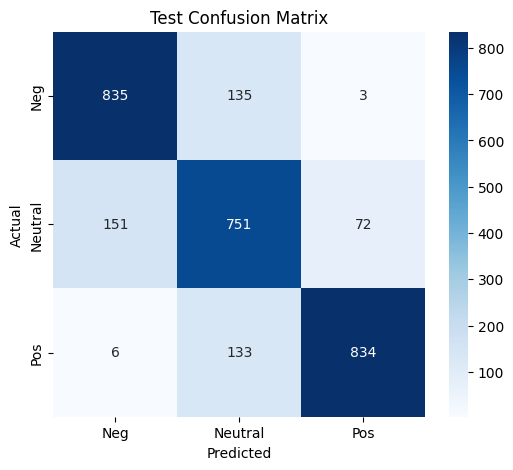

In [12]:
def plot_cm(true, pred, name):
    cm = confusion_matrix(true, pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Neg", "Neutral", "Pos"], yticklabels=["Neg", "Neutral", "Pos"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

plot_cm(test_labels, test_preds, "Test")


## Prediction

In [9]:
def predict_sample(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()
    return ["Negative", "Neutral", "Positive"][pred]

# Try a few custom texts
samples = [
    "This phone is amazing! Totally worth the price.",
    "Battery life is okay, not the best.",
    "Terrible product. I want a refund.",
    "Arrived early, but the phone is not good at all",
    "Arrived late, but the phone is so good",
]

for text in samples:
    print(f"📝 \"{text}\" → Prediction: {predict_sample(text)}")


📝 "This phone is amazing! Totally worth the price." → Prediction: Positive
📝 "Battery life is okay, not the best." → Prediction: Neutral
📝 "Terrible product. I want a refund." → Prediction: Negative
📝 "Arrived early, but the phone is not good at all" → Prediction: Neutral
📝 "Arrived late, but the phone is so good" → Prediction: Positive


## Gradio Development

In [ ]:
import gradio as gr
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from datetime import datetime
import csv
import os

# Load model and tokenizer
model_path = "/content/drive/MyDrive/sentiment_bert_balanced/model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
colors = {"Negative": "red", "Neutral": "gray", "Positive": "green"}
FEEDBACK_FILE = "user_feedback.csv"

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1).squeeze()
        predicted_class = torch.argmax(probs).item()

    label = label_map[predicted_class]
    confidence = probs[predicted_class].item()
    warning = "<br><span style='color:orange'>⚠️ Low confidence. Try rephrasing the review.</span>" if confidence < 0.5 else ""

    result_html = f"""
    <div style="border: 2px solid {colors[label]}; padding: 10px; border-radius: 10px;">
        <h3 style='margin-bottom: 5px;'>Prediction: <span style='color:{colors[label]}'>{label}</span></h3>
        <p>Confidence: {confidence:.2%}</p>
        {warning}
    </div>
    """
    return result_html, label, confidence

def save_feedback(label, confidence, correct):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    file_exists = os.path.isfile(FEEDBACK_FILE)
    with open(FEEDBACK_FILE, mode="a", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(["timestamp", "predicted_label", "confidence", "correct_prediction"])
        writer.writerow([timestamp, label, f"{confidence:.2%}", correct])
    return "✅ Thanks for your feedback!"

with gr.Blocks(title="Amazon Review Sentiment App") as demo:
    gr.Markdown(
        "<div style='text-align: center; font-size: 24px;'> <b> 💬📊 Review Analyzer</b></div>"
    )

    gr.Markdown("Enter a review below to check if it's **Positive 😊**, **Neutral 😐**, or **Negative 😞**.")

    with gr.Row():
        review_input = gr.Textbox(lines=10, placeholder="Type or paste a review here...", label="Your Review")
        output_box = gr.HTML(label="Prediction Result")

    predict_btn = gr.Button("🔍 Predict Sentiment")
    hidden_label = gr.Textbox(visible=False)
    hidden_conf = gr.Number(visible=False)

    with gr.Row():
        yes_btn = gr.Button("👍 Yes")
        no_btn = gr.Button("👎 No")

    feedback_output = gr.Textbox(label="Feedback Status", interactive=False)

    predict_btn.click(fn=predict_sentiment, inputs=[review_input], outputs=[output_box, hidden_label, hidden_conf])
    yes_btn.click(fn=save_feedback, inputs=[hidden_label, hidden_conf, gr.Textbox(value="yes", visible=False)], outputs=feedback_output)
    no_btn.click(fn=save_feedback, inputs=[hidden_label, hidden_conf, gr.Textbox(value="no", visible=False)], outputs=feedback_output)

    gr.Examples(
        examples=[
            "This phone exceeded all my expectations.",
            "Battery life is just okay, not great.",
            "Worst product I've ever purchased.",
            "Highly recommended!",
            "Meh. It's just fine, nothing special."
        ],
        inputs=review_input
    )

demo.launch(debug=True)
